In [1]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_palette("colorblind")

import pandas as pd
import numpy as np

import george
from george import kernels

import corner

In [2]:
datadir = "."

In [3]:
d1 = pd.read_csv(os.path.join(datadir, "all_lc.txt"), delim_whitespace=True)
d_ztf = d1.query('Mag_err == 0.03')
d_ztf.columns = ['Times', 'Mags', 'Mag_errs', 'TrueMag']
d_ztf[0:3]

,Times,Mags,Mag_errs,TrueMag
0,5.003086,-0.027480,0.03,-0.044916
1,5.037808,-0.204242,0.03,-0.202918
2,8.005668,-0.223226,0.03,-0.200683


Text(0,0.5,'Magnitude')

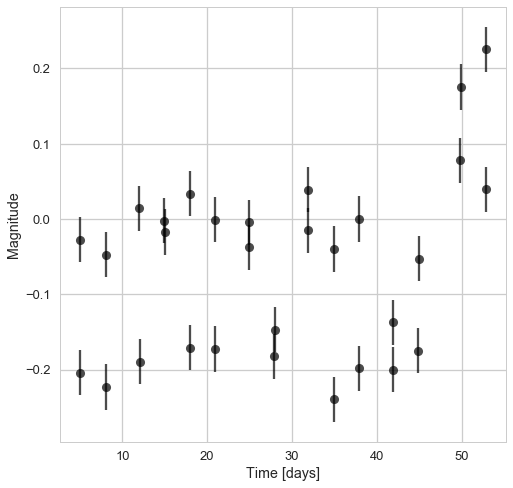

In [4]:
plt.figure(figsize=(8, 8))
plt.errorbar(d_ztf.Times, d_ztf.Mags, yerr=d_ztf.Mag_errs, fmt="o", c="black", alpha=0.7)
plt.xlabel("Time [days]")
plt.ylabel("Magnitude")

Let's define some starting parameters:

In [5]:
true_period = 4.196
true_period_days = true_period/24.0

In [6]:
time = np.array(d_ztf.Times)
mag = np.array(d_ztf.Mags)
mag_err = np.array(d_ztf.Mag_errs)

In [7]:
start_amp = np.var(mag)
start_gamma= 1.0
start_logperiod = np.log(true_period/24.0)

In [8]:
k = start_amp * kernels.ExpSine2Kernel(gamma=start_gamma, log_period=start_logperiod)

In [9]:
import george
gp = george.GP(k, mean=np.mean(mag), fit_mean=False)#,
               #white_noise=np.log(np.mean(mag_err)**2.), fit_white_noise=True)
gp.compute(time, mag_err)
print(gp.log_likelihood(mag))
print(gp.grad_log_likelihood(mag))


44.9438778907
[  5.96013219e+00   9.47897492e+00  -1.97354975e+04]


In [10]:
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(mag, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(mag, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(time, mag_err)

# Print the initial ln-likelihood.
print(gp.log_likelihood(mag))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(mag))

44.9438778907
51.8850088764


In [12]:
gp.get_parameter_dict()

OrderedDict([('kernel:k1:log_constant', -3.6047646160903186),
             ('kernel:k2:gamma', 2.1259624812586222),
             ('kernel:k2:log_period', -1.7440482496055041)])

best period 4.19547087668


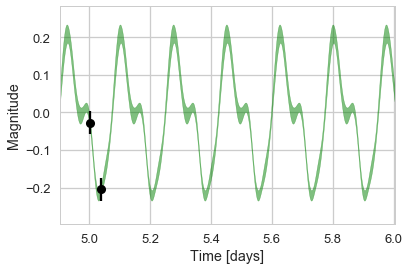

In [16]:
print('best period', np.power(np.e, gp.get_parameter_dict()['kernel:k2:log_period']) * 24.0)
x = np.linspace(np.min(time)-0.1, np.min(time)+1.0, 2000)
mu, var = gp.predict(mag, x, return_var=True)
std = np.sqrt(var)

plt.figure()
plt.errorbar(time, mag, yerr=mag_err, fmt="o", color="black")
plt.fill_between(x, mu+std, mu-std, color="g", alpha=0.5)

plt.xlim(time.min()-0.1, time.min()+1.0)
plt.xlabel("Time [days]")
plt.ylabel("Magnitude");

What are the best-fit parameters?

In [17]:
gp.get_parameter_dict()

OrderedDict([('kernel:k1:log_constant', -3.6047646160903186),
             ('kernel:k2:gamma', 2.1259624812586222),
             ('kernel:k2:log_period', -1.7440482496055041)])

In [18]:
def lnprob(p):
    #m = p[0] # mean
    logamp = p[0] # log amp
    gamma = p[1] # gamma
    log_period = p[2] # log period
    
    #if (p[0] < -0.1) or (p[0] > 0.1):
    #    return -np.inf
    if (p[0] < -10.0) or (p[0] > 5.0):
        return -np.inf
    elif (p[1] < 0.01) or (p[1] > 20.0):
        return -np.inf
    elif (p[2] < np.log(1.0/24.0)) or (p[2] > np.log(1.0)):
        return -np.inf
    else:

        # Update the kernel and compute the lnlikelihood.
        gp.set_parameter_vector(p)
        return gp.lnlikelihood(mag, quiet=True)

In [19]:
lnprob(gp.get_parameter_vector())

51.88500887635491

In [20]:
import emcee

gp.compute(time, mag_err)

# Set up the sampler.
nwalkers, ndim = 36, len(gp)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)


In [21]:
# Initialize the walkers.
p0 = gp.get_parameter_vector() + 0.0001 * np.random.randn(nwalkers, ndim)

In [22]:
print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, 5000)

Running burn-in


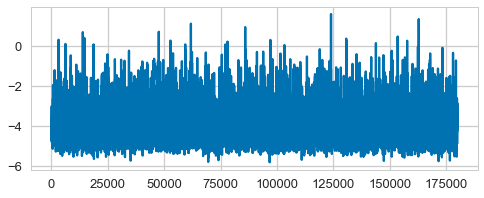

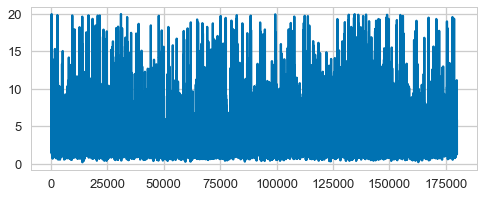

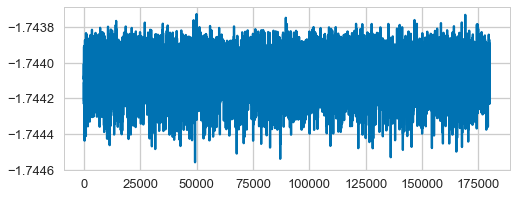

In [23]:
for i in range(sampler.flatchain.shape[1]):
    fig, ax = plt.subplots(1, 1, figsize=(8,3))
    ax.plot(sampler.flatchain[:,i])

In [24]:
sampler.reset()
print("Running production chain")
sampler.run_mcmc(p0, 2000);

Running production chain


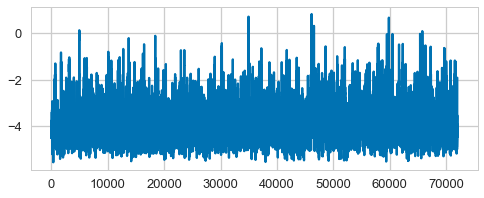

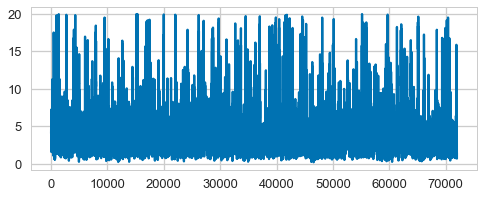

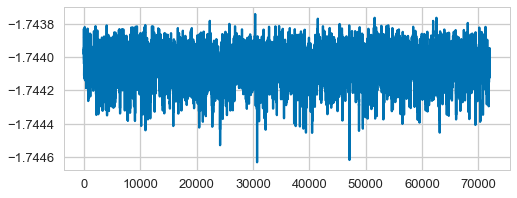

In [25]:
for i in range(sampler.flatchain.shape[1]):
    fig, ax = plt.subplots(1, 1, figsize=(8,3))
    ax.plot(sampler.flatchain[:,i])

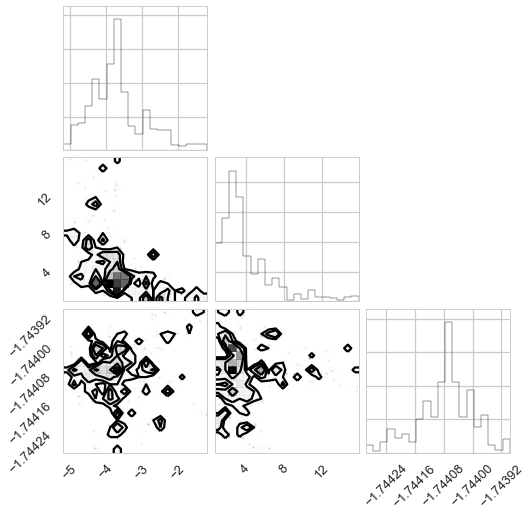

In [26]:
corner.corner(sampler.flatchain[-500:,:]);

Text(0.5,0,'Period (hours)')

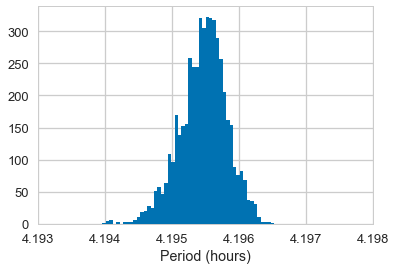

In [35]:
plt.figure()
n, b, p = plt.hist(np.exp(sampler.flatchain[-5000:, -1])*24.0, bins=50)
plt.xlim(4.193, 4.198)
plt.xlabel('Period (hours)')

In [37]:
time_phased = time/(4.196/24.0)

In [38]:
(time % (4.196/24.0)) * 24

array([ 2.586064,  3.419392,  3.316032,  4.116048,  2.239544,  2.922872,
        1.963672,  2.630344,  2.072352,  2.889024,  2.314088,  2.897408,
        1.965088,  2.565088,  2.765832,  3.482496,  1.342256,  2.158928,
        3.375568,  4.075576,  2.322456,  2.922456,  3.218   ,  3.934664,
        3.443848,  3.993832,  0.132984,  0.832968,  0.71432 ,  1.31432 ])

In [39]:
time_phased = (time_phased - np.floor(time_phased))*(4.196/24.0)

In [40]:
post_p = np.exp(sampler.flatchain[-5000:, -1])

In [41]:
np.mean(post_p*24.0)

4.1954718733042213

In [42]:
np.std(post_p*24.0)

0.00034790037757535439

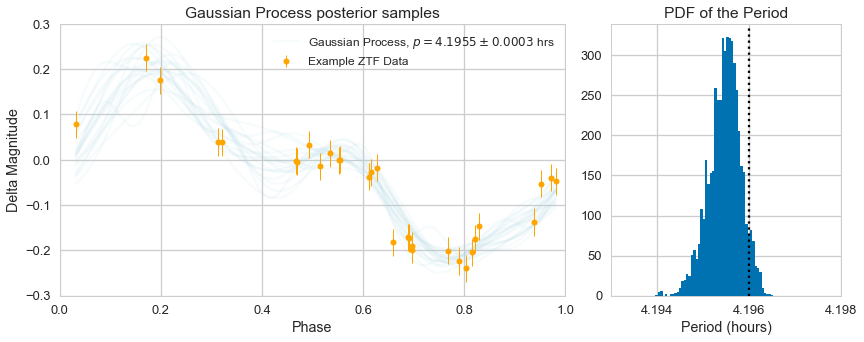

In [66]:
fig = plt.figure(figsize=(14,5))
grid = plt.GridSpec(1, 3, wspace=0.2)
ax = plt.subplot(grid[0, 0:2])
x = np.linspace(time_phased.min(), time_phased.max(), 500) 
ax.errorbar(time_phased *24.0/ fit_period, mag, yerr=mag_err, fmt="o", c="orange", ms=6, lw=1,
            label="Example ZTF Data", zorder=999)
np.random.seed(180401)
fit_period = np.mean(post_p*24.0)
uncertainty = np.std(post_p*24.0)
for i in range(20):
    # Choose a random walker and step.
    w = np.random.randint(5000)
    
    gp.set_parameter_vector(sampler.flatchain[-5000+w, :])

    # Plot a single sample.
    if i == 0:
        ax.plot(x *24./fit_period, gp.sample_conditional(mag, x), "lightblue", 
                alpha=0.1, label=r"Gaussian Process, $p=%.4f \pm %.4f$ hrs" % (fit_period, uncertainty))
    else:
        ax.plot(x *24. /fit_period, gp.sample_conditional(mag, x), "lightblue", alpha=0.1)

#ax.vlines(time[0]+4.0/24.0, 14.7, 15.3, lw=3, color="black")
ax.legend(fontsize='large', loc=1)
#ax.set_xlim(time_phased.min() * 24.0, np.max(x) * 24.0)
ax.set_xlim(0, 1)
ax.set_ylim(-0.3, 0.3)
ax.set_xlabel("Phase")
ax.set_ylabel("Delta Magnitude");
ax.set_title("Gaussian Process posterior samples")
ax2 = plt.subplot(grid[0, 2])
n, b, p = plt.hist(np.exp(sampler.flatchain[-5000:, -1])*24.0, bins=50)
plt.axvline(true_period, color='k', linestyle=':')
plt.xlim(4.193, 4.198)
plt.xlabel('Period (hours)')
plt.title('PDF of the Period')
plt.savefig('GP_posteriors.eps', format='eps')